## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [2]:
# answer goes here
crash = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')
crash['DAMAGE_C'] = crash['DAMAGE'] == 'OVER $1,500'

def missingness_summary(df,print_log,sort):
  percentage_null = df.isnull().sum()*100/df.isnull().count()
  if sort == 'ascending':
    return percentage_null.sort_values()
  elif sort == 'descending':
    return percentage_null.sort_values(ascending=False)
  else: 
    return percentage_null
crash_1 = missingness_summary(crash,0,'descending')
crash_1 = crash_1.loc[crash_1 > 5.0].index


crash['INJURIES_TOTAL'].fillna(crash['INJURIES_TOTAL'].median(), inplace=True)
crash['INJURIES_FATAL'].fillna(crash['INJURIES_FATAL'].median(), inplace=True)
crash['INJURIES_INCAPACITATING'].fillna(crash['INJURIES_INCAPACITATING'].median(), inplace=True)
crash['INJURIES_NON_INCAPACITATING'].fillna(crash['INJURIES_NON_INCAPACITATING'].median(), inplace=True)
crash['INJURIES_REPORTED_NOT_EVIDENT'].fillna(crash['INJURIES_REPORTED_NOT_EVIDENT'].median(), inplace=True)
crash['INJURIES_NO_INDICATION'].fillna(crash['INJURIES_NO_INDICATION'].median(), inplace=True)
crash['INJURIES_UNKNOWN'].fillna(crash['INJURIES_UNKNOWN'].median(), inplace=True)
crash['NUM_UNITS'].fillna(crash['NUM_UNITS'].median(), inplace=True)
crash['BEAT_OF_OCCURRENCE'].fillna(crash['BEAT_OF_OCCURRENCE'].median(), inplace=True)


crash = crash.drop(columns=crash_1, axis=1)
crash = crash.dropna()
missingness_summary(crash,0,'descending')

DAMAGE_C                         0.0
INJURIES_UNKNOWN                 0.0
CRASH_DATE                       0.0
POSTED_SPEED_LIMIT               0.0
TRAFFIC_CONTROL_DEVICE           0.0
DEVICE_CONDITION                 0.0
WEATHER_CONDITION                0.0
LIGHTING_CONDITION               0.0
FIRST_CRASH_TYPE                 0.0
TRAFFICWAY_TYPE                  0.0
ALIGNMENT                        0.0
ROADWAY_SURFACE_COND             0.0
ROAD_DEFECT                      0.0
REPORT_TYPE                      0.0
CRASH_TYPE                       0.0
DAMAGE                           0.0
DATE_POLICE_NOTIFIED             0.0
PRIM_CONTRIBUTORY_CAUSE          0.0
SEC_CONTRIBUTORY_CAUSE           0.0
STREET_NO                        0.0
STREET_DIRECTION                 0.0
STREET_NAME                      0.0
BEAT_OF_OCCURRENCE               0.0
NUM_UNITS                        0.0
MOST_SEVERE_INJURY               0.0
INJURIES_TOTAL                   0.0
INJURIES_FATAL                   0.0
I

In [3]:
new_crash = crash.filter(['POSTED_SPEED_LIMIT', 'INJURIES_TOTAL'])
weather = pd.get_dummies(crash["WEATHER_CONDITION"], drop_first=True)
crashtype = pd.get_dummies(crash['FIRST_CRASH_TYPE'], drop_first=True)
new_crash = pd.concat([new_crash, weather], axis=1)
new_crash = pd.concat([new_crash, crashtype], axis=1)
new_crash

,POSTED_SPEED_LIMIT,INJURIES_TOTAL,CLEAR,CLOUDY/OVERCAST,FOG/SMOKE/HAZE,FREEZING RAIN/DRIZZLE,OTHER,RAIN,SEVERE CROSS WIND GATE,SLEET/HAIL,SNOW,UNKNOWN,ANIMAL,FIXED OBJECT,HEAD ON,OTHER NONCOLLISION,OTHER OBJECT,OVERTURNED,PARKED MOTOR VEHICLE,PEDALCYCLIST,PEDESTRIAN,REAR END,REAR TO FRONT,REAR TO REAR,REAR TO SIDE,SIDESWIPE OPPOSITE DIRECTION,SIDESWIPE SAME DIRECTION,TRAIN,TURNING
6,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,30,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,30,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372578,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
372579,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
372581,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
372583,30,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split

X = new_crash
Y = crash['DAMAGE_C']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)

sm_model = sm.Logit(y_train, X_train_const).fit()
print(sm_model.summary())



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.658051
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               DAMAGE_C   No. Observations:               289986
Model:                          Logit   Df Residuals:                   289956
Method:                           MLE   Df Model:                           29
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                 0.03995
Time:                        15:58:26   Log-Likelihood:            -1.9083e+05
converged:                       True   LL-Null:                   -1.9877e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7375      0.736      1.002      0.317

In [5]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)
results = pd.DataFrame(columns=['actual', 'predict', 'probability'])

results['actual'] = y_test
results['predict'] = logit.predict(X_test)
results['probability'] = logit.predict_proba(X_test)[:,1]



In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, results['predict'])

array([[ 9681, 22107],
       [ 7950, 32759]])

In [7]:
from sklearn.metrics import log_loss
log_loss(y_test, results['predict'])

14.319898462035942

In [8]:
log_loss(y_train, logit.predict(X_train))

14.387887330129484

Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [9]:
# answer goes here
from sklearn.model_selection import cross_val_score
from sklearn import svm





In [32]:
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_log_loss')
scores.mean()

-0.677348027423328

Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

In [38]:
# answer goes here
x=1
while (x<6):
  logit = LogisticRegression(max_iter=1000, C=x)
  logit.fit(X_train, y_train)
  scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_log_loss')
  print(x)
  print(scores.mean())
  x = x+1





1
-0.676586960132558
2
-0.6783470798529652
3
-0.6782563446563556
4
-0.6786321312358108
5
-0.6778974992501435


when C = 4, the absolute value of score is the highest

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [41]:
# answer goes here
logit = LogisticRegression(max_iter=1000, C=4)
logit.fit(X_train, y_train)

from sklearn.metrics import classification_report
classification_report(y_train, logit.predict(X_train))



'              precision    recall  f1-score   support\n\n       False       0.54      0.30      0.39    127011\n        True       0.60      0.80      0.68    162975\n\n    accuracy                           0.58    289986\n   macro avg       0.57      0.55      0.54    289986\nweighted avg       0.57      0.58      0.55    289986\n'

In [43]:
confusion_matrix(y_train, logit.predict(X_train))

array([[ 38436,  88575],
       [ 32231, 130744]])

In [44]:
from sklearn import metrics
metrics.roc_curve(y_train, logit.predict(X_train))

(array([0.        , 0.69738054, 1.        ]),
 array([0.        , 0.80223347, 1.        ]),
 array([2, 1, 0]))

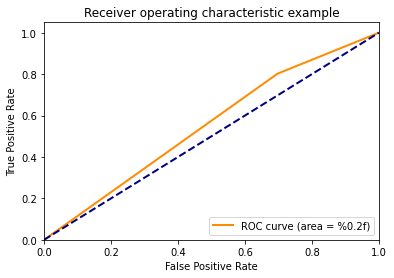

In [47]:
plt.figure()
lw = 2
plt.plot(metrics.roc_curve(y_train, logit.predict(X_train))[0], metrics.roc_curve(y_train, logit.predict(X_train))[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()